# Imports

In [1]:
# filtering messages to error
import warnings
import os

warnings.filterwarnings('ignore')
os.environ['TF_CPP_MIN_LOG_LEVEL'] = '3'

In [2]:
# python imports
from timeit import default_timer as timer
from datetime import timedelta

# third-party imports
import numpy as np

from sklearn.ensemble import GradientBoostingClassifier
from sklearn.preprocessing import StandardScaler
from sklearn.metrics import ConfusionMatrixDisplay

import tensorflow as tf
from tensorflow import keras
from tensorflow.keras import layers

from matplotlib import pyplot as plt
%matplotlib inline

# project imports
from utils.al import active_learn_loop
from utils.data import load_data
from utils.data import initial_query_test_split

# [VAE](https://en.wikipedia.org/wiki/Variational_autoencoder)

In [3]:
def create_autoencoder(X_train, input_dim, latent_dim):
    class Sampling(layers.Layer):
        """Uses (z_mean, z_log_var) to sample z, the vector encoding a digit."""

        def call(self, inputs):
            z_mean, z_log_var = inputs
            batch = tf.shape(z_mean)[0]
            dim = tf.shape(z_mean)[1]
            epsilon = tf.keras.backend.random_normal(shape=(batch, dim))
            return z_mean + tf.exp(0.5 * z_log_var) * epsilon
    
    class VAE(keras.Model):
        def __init__(self, encoder, decoder, **kwargs):
            super(VAE, self).__init__(**kwargs)
            self.encoder = encoder
            self.decoder = decoder

        def train_step(self, data):
            if isinstance(data, tuple):
                data = data[0]

            with tf.GradientTape() as tape:
                z_mean, z_log_var, z = encoder(data)
                reconstruction = decoder(z)
                reconstruction_loss = tf.reduce_mean(
                    keras.losses.mean_squared_error(data, reconstruction))

                reconstruction_loss *= input_dim
                kl_loss = 1 + z_log_var - tf.square(z_mean) - tf.exp(z_log_var)
                kl_loss = tf.reduce_mean(kl_loss)
                kl_loss *= -0.5
                total_loss = reconstruction_loss + kl_loss

            grads = tape.gradient(total_loss, self.trainable_weights)
            self.optimizer.apply_gradients(zip(grads, self.trainable_weights))

            return {"loss": total_loss,
                    "reconstruction_loss": reconstruction_loss,
                    "kl_loss": kl_loss}
    
    # encoder 
    encoder_inputs = keras.Input(shape=input_dim)
    x = layers.Dense(64, activation="relu")(encoder_inputs)
    x = layers.Dense(64, activation="relu")(x)
    z_mean = layers.Dense(latent_dim, name="z_mean")(x)
    z_log_var = layers.Dense(latent_dim, name="z_log_var")(x)
    z = Sampling()([z_mean, z_log_var])
    
    encoder = keras.Model(encoder_inputs, [z_mean, z_log_var, z], name="encoder") 
    
    # decoder
    latent_inputs = keras.Input(shape=latent_dim)
    x = layers.Dense(64, activation="relu")(latent_inputs)
    x = layers.Dense(64, activation="relu")(x)
    decoder_outputs = layers.Dense(input_dim, activation="linear", name="decoder_output")(x)
    
    decoder = keras.Model(latent_inputs, decoder_outputs, name="decoder")
           
    start = timer()
    
    # running vae
    vae = VAE(encoder, decoder)
    vae.compile(optimizer=keras.optimizers.Adam())
    vae.fit(X_train, epochs=500, batch_size=64, verbose=False)
    
    elapsed = timer() - start
    
    return encoder, elapsed

# Loading Data

In [4]:
X_unlabeled, _ = load_data('datasets/vulns-unlabeled.csv')
X_labeled, y_labeled = load_data('datasets/vulns-labeled.csv')

# Pipeline

In [5]:
def run_pipeline(active_model, super_model, 
                 X_unlabeled, X_labeled, y_labeled, 
                 initial_size, test_size, 
                 n_queries, n_interactions, 
                 scale_active_data, scale_super_data, 
                 encode_beggining, encode_ending, verbose):
    
    elapsed_list = list()
    acc_active_list = list()
    acc_super_list = list()

    print(f'\n# {str(active_model)} + {str(super_model)}\n')

    for i in range(n_interactions):

        # Splitting data
        # --------------

        X_initial, X_query, X_test, y_initial, y_query, y_test =\
            initial_query_test_split(X_labeled, y_labeled, initial_size, test_size)
        
        X_all = np.append(np.append(X_initial, X_query, axis=0), X_unlabeled, axis=0)
        
        # Encoding data with VAE
        # ----------------------      
        
        elapsed_vae = 0
        if encode_beggining:
            scaler = StandardScaler().fit(X_all)
            
            X_all = scaler.transform(X_all)
            X_initial = scaler.transform(X_initial)
            X_query = scaler.transform(X_query)
            X_test = scaler.transform(X_test)
            
            encoder, elapsed_vae = create_autoencoder(X_all, input_dim=X_all.shape[1], latent_dim=10)
            
            X_all = encoder(X_all)[0].numpy()
            X_initial = encoder(X_initial)[0].numpy()
            X_query = encoder(X_query)[0].numpy()
            X_test = encoder(X_test)[0].numpy() 
        
        # Active learning
        # ---------------
        
        # scaling data if necessary
        scaler = None
        if scale_active_data:
            scaler = StandardScaler().fit(X_query)
        
            X_initial = scaler.transform(X_initial)
            X_query = scaler.transform(X_query)
            X_test = scaler.transform(X_test)
        
        # active learner loop
        learner_active, elapsed_active, X_train, y_train =\
            active_learn_loop(active_model, X_initial, y_initial, X_query, y_query, n_queries)
        
        # calculate score
        acc_active = learner_active.score(X_test, y_test)
        acc_active_list.append(acc_active)
        
        # denormalize data if necessary
        if scale_active_data:
            X_train = scaler.inverse_transform(X_train)
            X_test = scaler.inverse_transform(X_test)
            
                
        # Encoding data with VAE
        # ----------------------      
        
        elapsed_vae = 0
        if encode_ending:
            scaler = StandardScaler().fit(X_all)
            
            X_all = scaler.transform(X_all)
            X_train = scaler.transform(X_train)
            X_test = scaler.transform(X_test)
            
            encoder, elapsed_vae = create_autoencoder(X_all, input_dim=X_all.shape[1], latent_dim=10)
            
            X_train = encoder(X_train)[0].numpy()
            X_test = encoder(X_test)[0].numpy()

        # Supervised learning
        # ------------------------
        
        # scalling data if necessary
        if scale_super_data:
            scaler = StandardScaler().fit(X_train)
            
            X_train = scaler.transform(X_train)
            X_test = scaler.transform(X_test)
        
        start = timer()
        
        super_model.fit(X_train, y_train)
        
        elapsed_super = timer() - start
        
        acc_super = super_model.score(X_test, y_test)
        acc_super_list.append(acc_super)
        
        # Calculating elapsed time
        # ------------------------
        
        elapsed = elapsed_active + elapsed_vae + elapsed_super
        elapsed_list.append(elapsed)

        if i % 5 == 0 and verbose:
            print(f'Progress {round((i/n_interactions) * 100)}%')

    # Printing statistics
    # -------------------
    
    print(f'\n(len(X_initial), len(X_train), len(X_test)) = {(len(X_initial), len(X_train), len(X_test))}\n')
    
    if encode_beggining:
        print('(data encoded before active learning)\n')
    elif encode_ending:
        print('(data encoded after active learning)\n')
    
    print(' - Avg. accuracy:')
    print(f'   - Active learning: {np.mean(acc_active_list):.2f} (max={max(acc_active_list)})')
    print(f'   - Supervised learning: {np.mean(acc_super_list):.2f} (max={max(acc_super_list)})')
    print(f' - Elapsed time: {timedelta(seconds=(np.sum(elapsed_list)))}')
    print(f' - Confusion matrix:')
    ConfusionMatrixDisplay.from_estimator(super_model, X_test, y_test, cmap=plt.cm.Blues)
    plt.show()

# Runs


# GradientBoostingClassifier() + GradientBoostingClassifier()


(len(X_initial), len(X_train), len(X_test)) = (20, 120, 40)

(data encoded before active learning)

 - Avg. accuracy:
   - Active learning: 0.53 (max=0.7)
   - Supervised learning: 0.47 (max=0.65)
 - Elapsed time: 0:12:27.184646
 - Confusion matrix:


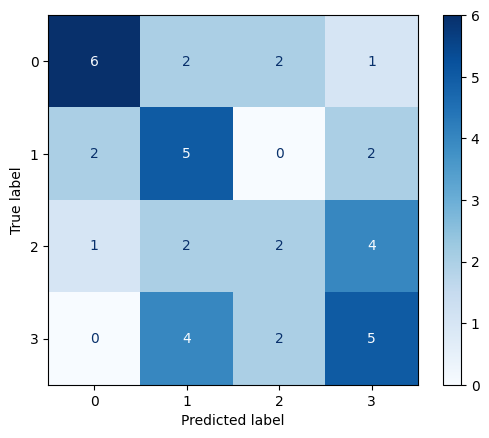

In [6]:
run_pipeline(GradientBoostingClassifier(), GradientBoostingClassifier(),
             X_unlabeled, X_labeled, y_labeled, initial_size=20, test_size=40,
             n_queries=100, n_interactions=30,
             scale_active_data=False, scale_super_data=False, 
             encode_beggining=True, encode_ending=False, verbose=False)


# GradientBoostingClassifier() + GradientBoostingClassifier()


(len(X_initial), len(X_train), len(X_test)) = (20, 120, 40)

(data encoded after active learning)

 - Avg. accuracy:
   - Active learning: 0.74 (max=0.85)
   - Supervised learning: 0.53 (max=0.675)
 - Elapsed time: 0:16:49.236006
 - Confusion matrix:


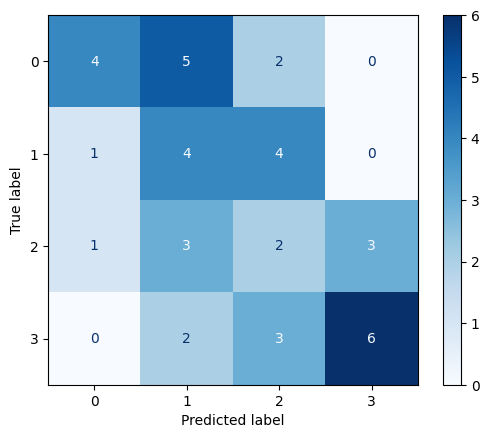

In [7]:
run_pipeline(GradientBoostingClassifier(), GradientBoostingClassifier(),
             X_unlabeled, X_labeled, y_labeled, initial_size=20, test_size=40,
             n_queries=100, n_interactions=30,
             scale_active_data=False, scale_super_data=False, 
             encode_beggining=False, encode_ending=True, verbose=False)